In [1]:
# maximize reproducibility: set seed with minimal imports
# just a seed
seed = 431136
import os

# verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# reproducibility
# https://github.com/NVIDIA/framework-determinism
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random

random.seed(seed)
rng_r = random.Random(seed + 1)

import numpy as np

np.random.seed(seed + 2)
rng_np = np.random.default_rng(seed + 3)

import tensorflow as tf

tf.random.set_seed(seed + 4)

In [33]:
%load_ext autoreload
%autoreload 2
from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import seaborn as sns

import pandas as pd

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# from posthoceval.explainers import KernelSHAPExplainer
# from posthoceval.explainers import MAPLEExplainer
from posthoceval.explainers import *

from posthoceval.models.gam import MultiClassLogisticGAM
from posthoceval.models.gam import LinearGAM
from posthoceval.models.gam import T
from posthoceval.models.dnn import AdditiveDNN
from posthoceval.transform import Transformer
from posthoceval.utils import nonexistent_filename
from posthoceval.datasets import COMPASDataset
from posthoceval.datasets import BostonDataset
from posthoceval.datasets import HELOCDataset
from posthoceval.models.term_util import generate_terms
from posthoceval.viz import gather_viz_data
from posthoceval import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sns.set_theme(
    # context='paper',
    context='notebook',
    style='ticks',
    font_scale=1,  # 2.25,
    color_codes=True,
    # palette=sns.color_palette('pastel'),
)

In [4]:
def mpl_backend(backend='inline'):
    rc = plt.rcParams.copy()
    # backend = plt.get_backend()
    %matplotlib $backend
    
mpl_inline = lambda: mpl_backend('inline')
mpl_qt = lambda: mpl_backend('qt')
mpl_notebook = lambda: mpl_backend('notebook')
mpl_backend('nbagg')

In [5]:
dataset_name = 'heloc'

if dataset_name == 'synthetic':
    raise NotImplementedError
    task = 'regression'

    # import numpy
    # X = np.random.rand(1000, 8) / 4
    # x1, x2, x3, x4, x5, x6, x7, x8 = X.T
    # y = (x1 ** 2 + x5 ** 2 + x5 * numpy.log(x1 + x2) +
    #      x7 * numpy.select([numpy.greater(x2, numpy.sinc(x1 / numpy.pi)),
    #                         True],
    #                        [numpy.asarray(x2 ** (-1.0)).astype(numpy.bool),
    #                         numpy.asarray(numpy.sinc(x1 / numpy.pi) ** (-1.0)
    #                                       ).astype(numpy.bool)],
    #                        default=numpy.nan) + (
    #              x1 * abs(x7) + x5) ** 3 + numpy.exp(x7) + numpy.exp(
    #             (x1 + x2) / x5) + numpy.sin(numpy.log(x2)))

    # X = np.random.randn(1000, 4)
    # x1, x2, x3, x4 = X.T
    # x1 = np.abs(x1)
    # x2 = np.abs(x2)
    # y = x1 ** (1 / 4) + np.sqrt(x2) + np.exp(x3 / 2) + np.abs(x4) + np.tan(
    #     x4) / x1 ** 2

    # X = np.random.randn(1000, 2)
    # y = X[:, 0] ** 9 + np.tan(X[:, 1]) + np.abs(X[:, 0] / X[:, 1] ** 2)

    # X = np.random.randn(1000, 400)
    # y = np.exp(np.random.randn(len(X)))

    # X[:, 1] = X[:, 0] / 2
    # X[:, 2] = X[:, 1] + 1
    # X[:, 3] = X[:, 2] * 2.6
    # y = (np.sin(X[:, 0] ** 3) + np.maximum(X[:, 1], 0)
    #     - np.sin(X[:, 2]) / X[:, 2] + 2 * X[:, 3])

    feature_names = [*range(X.shape[1])]
elif dataset_name == 'compas':
    dataset_cls = COMPASDataset
elif dataset_name == 'heloc':
    dataset_cls = HELOCDataset
elif dataset_name == 'boston':
    dataset_cls = BostonDataset
else:
    raise NotImplementedError
    task = 'classification'
    # dataset = datasets.load_iris()
    # dataset = datasets.load_breast_cancer()
    dataset = datasets.load_wine()

    X = dataset.data
    y = dataset.target

# load dataset
dataset_orig = dataset_cls()

# transform data
transformer = Transformer()
dataset = transformer.fit_transform(dataset_orig)

# extract data
task = dataset.task
X = dataset.X
y = dataset.y
feature_names = dataset.feature_names
n_features = dataset.n_features

print(f'Samples     = {len(X)}')
print(f'Input Shape = {dataset.input_shape}')
print(f'Task        = {task}')

Samples     = 10459
Input Shape = (37,)
Task        = classification


In [6]:
# model
# model_type = 'gam'
model_type = 'dnn'

In [7]:
# put together terms
max_order = 3
min_order = 1

if dataset_name == 'heloc':
    n_main = n_features - 10
    desired_interactions = [(1, 2), (10, 12), (15, 18), (7, 11)]
else:
    desired_interactions = []
    n_main = n_features

n_interact = None if desired_interactions else None

# current interact plots use this: LIME, MAPLE
# desired_interactions = [(1, 2)]

# features 8 & 9 correlate in Boston dataset
# desired_interactions = [(8, 0, 1), (2, 8), (2, 9)]

terms = generate_terms(
    n_features=n_features,
    n_main=n_main,
    n_interact=n_interact,
    desired_interactions=desired_interactions,
    min_order=min_order,
    max_order=max_order,
    seed=rng_np,
)
# terms = [T.te(0, 1), T.te(2, 3), T.s(0, n_splines=50)]
# terms = [T.te(0, 1), T.te(1, 3, n_splines=5), T.s(2, n_splines=50)]

In [8]:
if model_type == 'dnn':
    callback = EarlyStopping(monitor='loss', mode='min', patience=5,
                             restore_best_weights=True)
    optimizer = Adam(learning_rate=1e-3)
    fit_kwargs = {'epochs': 50, 'batch_size': len(X),
                  'callbacks': [callback], 'optimizer': optimizer}
else:
    fit_kwargs = {}

# TODO: factor terms for categoricals in GAM?
# TODO: embed categoricals in NN?

if model_type == 'dnn':
    model = AdditiveDNN(
        terms=terms,
        task=task,
        symbol_names=feature_names,
        activation='sigmoid',
    )
elif model_type == 'gam':
    if task == 'classification':
        model = MultiClassLogisticGAM(symbol_names=feature_names, terms=terms)
    else:
        model = LinearGAM(symbol_names=feature_names, terms=terms)
else:
    raise NotImplementedError(model_type)

model.fit(X, y, **fit_kwargs)

if model_type == 'dnn':
    model.plot_model(nonexistent_filename('dnn.png'),
                     show_shapes=True)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 2.2198
Epoch 2/50
1/1 [==============================] - 0s 70ms/step - loss: 0.6996
Epoch 3/50
1/1 [==============================] - 0s 59ms/step - loss: 1.4359
Epoch 4/50
1/1 [==============================] - 0s 56ms/step - loss: 1.5141
Epoch 5/50
1/1 [==============================] - 0s 57ms/step - loss: 1.0536
Epoch 6/50
1/1 [==============================] - 0s 55ms/step - loss: 0.6889
Epoch 7/50
1/1 [==============================] - 0s 59ms/step - loss: 0.9524
Epoch 8/50
1/1 [==============================] - 0s 59ms/step - loss: 1.1579
Epoch 9/50
1/1 [==============================] - 0s 57ms/step - loss: 1.0302
Epoch 10/50
1/1 [==============================] - 0s 57ms/step - loss: 0.7647
Epoch 11/50
1/1 [==============================] - 0s 57ms/step - loss: 0.7032
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to wo

In [38]:
explain_only_this_many = 10
# explain_only_this_many = len(X)
explain_only_this_many = min(explain_only_this_many, len(X))
sample_idxs_all = np.arange(len(X))
sample_idxs = rng_np.choice(sample_idxs_all,
                            size=explain_only_this_many, replace=False)
X_subset = X[sample_idxs]
y_subset = y[sample_idxs]

true_contribs = model.feature_contributions(X_subset)

In [39]:
explainer_array = [
    # ('PDP', PDPExplainer),
    ('SHAPR', SHAPRExplainer),
    ('GradCAM', GradCAMExplainer),
    ('GradCAM-Smooth', GradCAMExplainer.smooth_grad),
    ('VanillaGradients', VanillaGradientsExplainer),
    ('VanillaGradients-Smooth', VanillaGradientsExplainer.smooth_grad),
    ('GradientsXInputs', GradientsXInputsExplainer),
    ('GradientsXInputs-Smooth', GradientsXInputsExplainer.smooth_grad),
    ('IntegratedGradients', IntegratedGradientsExplainer),
    ('IntegratedGradients-Smooth', IntegratedGradientsExplainer.smooth_grad),
    ('Occlusion', OcclusionExplainer),
    ('XRAI', XRAIExplainer),
    ('XRAI-Smooth', XRAIExplainer.smooth_grad),
    ('BlurIG', BlurIntegratedGradientsExplainer),
    ('BlurIG-Smooth', BlurIntegratedGradientsExplainer.smooth_grad),
    ('LIME', LIMEExplainer),
    ('SHAP', KernelSHAPExplainer),
]
if task == 'regression':
    explainer_array.append(('MAPLE', MAPLEExplainer))

# TODO: feature_contributions() --> explain()
# TODO: explain() --> ExplainerMixin (for both models and explainers)

pred_contribs_map = {}
pred_y_map = {}
for expl_i, (explainer_name, explainer_cls) in enumerate(explainer_array):
    print('Explaining model using', explainer_name)
    explainer = explainer_cls(model, seed=seed, task=task)
    explainer.fit(dataset)  # fit full dataset
    pred_contribs, y_pred = explainer.feature_contributions(
        X_subset, as_dict=True, return_predictions=True)

    # store for later viz data generation
    pred_contribs_map[explainer_name] = pred_contribs
    pred_y_map[explainer_name] = y_pred

Explaining model using PDP
(40,)


TypeError: 'PDPIsolate' object is not iterable

In [17]:
# TODO: import from viz and implement fully...
# plot_fit()

df, df_3d, contribs_df, err_dfs = gather_viz_data(
    model=model,
    dataset=dataset,
    transformer=transformer,
    true_contribs=true_contribs,
    pred_contribs_map=pred_contribs_map,
    dataset_sample_idxs=sample_idxs,
)

<IPython.core.display.Javascript object>


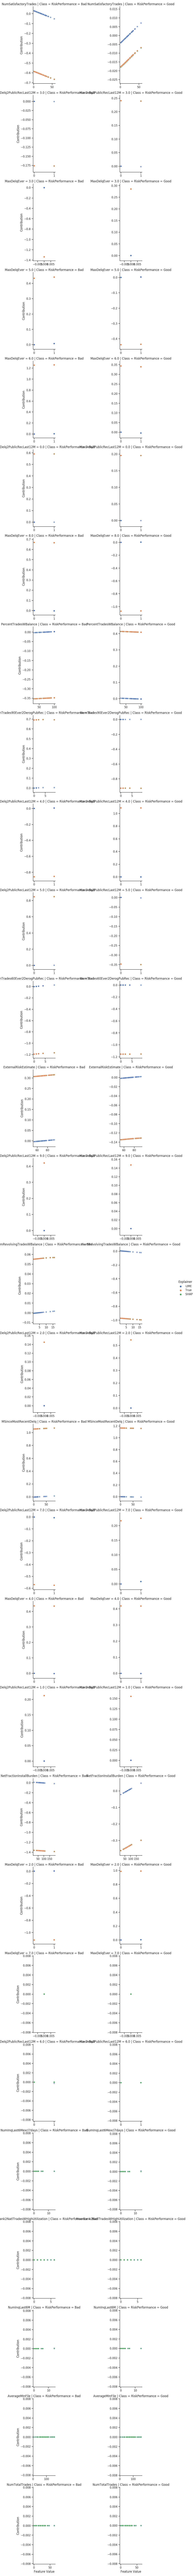

In [18]:
col_wrap = 4

if df is not None:
    # if n_features > 12 or task == 'classification':
    #     mpl_qt()
    # else:
    #     mpl_inline()
    g = sns.relplot(
        data=df,
        x='Feature Value',
        y='Contribution',
        hue='Explainer',
        # col='class' if task == 'classification' else 'true_effect',
        col='Class' if task == 'classification' else 'Match',
        col_wrap=None if task == 'classification' else col_wrap,
        # row='true_effect' if task == 'classification' else None,
        row='Match' if task == 'classification' else None,
        kind='scatter',
        x_jitter=.08,  # for visualization purposes of nearby points
        alpha=.65,
        facet_kws=dict(sharex=False, sharey=False),
    )
    for ax in g.axes.flat:
        title = ax.get_title()
        ax.set_title(title.split(' = ', 1)[1])
    g.tight_layout()
    g.savefig(nonexistent_filename(f'contributions_grid_{model_type}.pdf'))

<IPython.core.display.Javascript object>


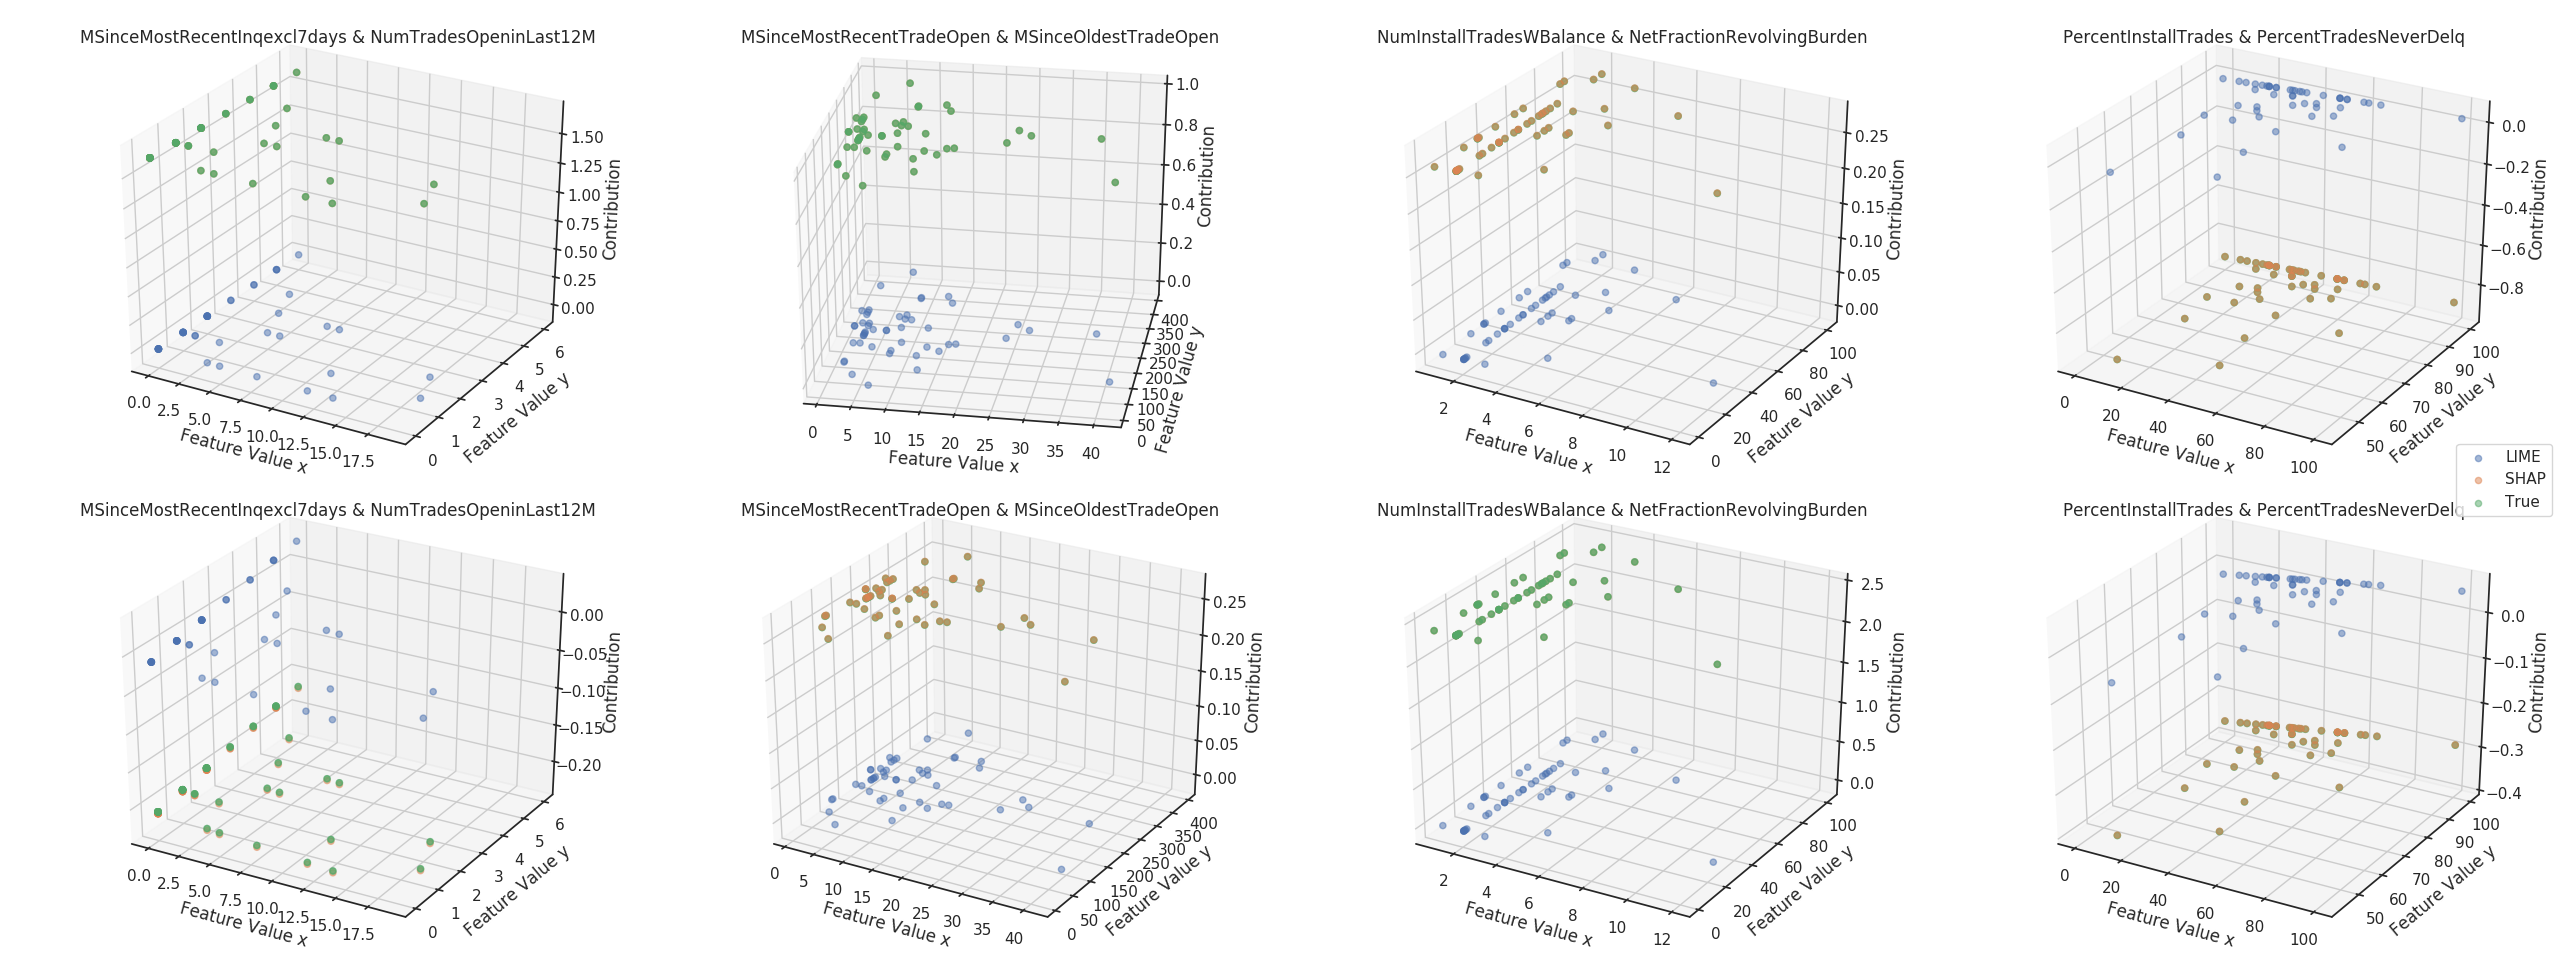

In [19]:
# 3d interaction plot time
if df_3d is not None:

    plt_x = 'Feature Value x'
    plt_y = 'Feature Value y'
    plt_z = 'Contribution'
    plt_hue = 'Explainer'
    plt_col = 'Match'

    df_3d_grouped = df_3d.groupby(['Class', plt_col])

    n_plots = len(df_3d_grouped)
    n_rows = int(np.ceil(n_plots / col_wrap))
    n_cols = min(col_wrap, n_plots)
    figsize = plt.rcParams['figure.figsize']
    figsize = (figsize[0] * n_cols, figsize[1] * n_rows)
    fig = plt.figure(figsize=figsize)

    for i, ((class_i, ax_title), group_3d) in enumerate(df_3d_grouped):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')

        for hue_name, hue_df in group_3d.groupby(plt_hue):
            ax.scatter(
                hue_df[plt_x],
                hue_df[plt_y],
                hue_df[plt_z],
                label=hue_name,
                alpha=.5,
            )
        ax.set_xlabel(plt_x)
        ax.set_ylabel(plt_y)
        ax.set_zlabel(plt_z)

        ax.set_title(ax_title)

        if i == 0:
            fig.legend(loc='center right')
    fig.tight_layout()
    fig.savefig(nonexistent_filename(
        f'contributions_grid_interact_{model_type}.pdf'))

In [20]:
err_dfs['effectwise_err_agg']

,Explainer,Class,Metric,Score
0,LIME,RiskPerformance = Bad,mean_absolute_percentage_error,3.148476e+09
1,LIME,RiskPerformance = Bad,normalized_root_mean_squared_error__normalize_...,1.162877e+15
2,LIME,RiskPerformance = Bad,normalized_root_mean_squared_error__normalize_...,8.863508e+09
3,LIME,RiskPerformance = Bad,pearson_correlation_coef,9.946325e-01
4,LIME,RiskPerformance = Bad,root_mean_squared_error,5.600326e-01
5,LIME,RiskPerformance = Bad,spearman_rank_correlation,8.957336e-01
6,LIME,RiskPerformance = Good,mean_absolute_percentage_error,2.877944e+09
7,LIME,RiskPerformance = Good,normalized_root_mean_squared_error__normalize_...,8.347363e+14
8,LIME,RiskPerformance = Good,normalized_root_mean_squared_error__normalize_...,3.896316e+13
9,LIME,RiskPerformance = Good,pearson_correlation_coef,8.615351e-01


In [25]:
err_dfs['samplewise_err_agg']

,Explainer,Class,Metric,Score
0,LIME,RiskPerformance = Bad,cosine_distances,1.006757e+00
1,LIME,RiskPerformance = Bad,euclidean_distances,4.222378e+00
2,LIME,RiskPerformance = Good,cosine_distances,1.055480e+00
3,LIME,RiskPerformance = Good,euclidean_distances,3.901871e+00
4,SHAP,RiskPerformance = Bad,cosine_distances,1.686219e-07
5,SHAP,RiskPerformance = Bad,euclidean_distances,2.643689e-03
6,SHAP,RiskPerformance = Good,cosine_distances,3.539030e-07
7,SHAP,RiskPerformance = Good,euclidean_distances,3.381633e-03


In [32]:
def effects_to_str(*effect_sets):
    effect_strs = []
    for effects_set in zip(*effect_sets):
        features = set()
        for effects in effects_set:
            for effect in effects:
                features.update(effect)
        effect_strs.append(' & '.join(map(str, features)))
    return effect_strs


def plot_explanation(
    explanation,
):
    contribs = contribs_df[(contribs_df['Explainer'] == explanation['Explainer']) &
                           (contribs_df['Class'] == explanation['Class'])]
    assert len(contribs) == 1
    # get contribs for true/pred
    contribs = contribs.iloc[0]
    true_contribs = contribs['True Contribs']
    pred_contribs = contribs['Pred Contribs']
    # get attributions for effects
    sample_idx = explanation['Sample Index']
    # pred
    sample_pred_contribs = pred_contribs.iloc[sample_idx]
    pred_effects = sample_pred_contribs.keys()
    pred_contribs = sample_pred_contribs.values
    # true
    sample_true_contribs = true_contribs.iloc[sample_idx]
    true_effects = sample_true_contribs.keys()
    true_contribs = sample_true_contribs.values
    # map to readable strings
    all_effects = effects_to_str(pred_effects, true_effects)
    # set up DF for plotting
    df_plot = pd.concat([
        pd.DataFrame({
            'Effect': all_effects,
            'Explainer': 'True',
            'Attribution': true_contribs,
        }),
        pd.DataFrame({
            'Effect': all_effects,
            'Explainer': explanation['Explainer'],
            'Attribution': pred_contribs,
        }),
    ], ignore_index=True)
    f, ax = plt.subplots()
    sns.barplot(y='Effect', x='Attribution', hue='Explainer',
                data=df_plot, ax=ax,
                orient='h')
    # ax.set_xscale('symlog')
    return ax

In [28]:
k = 3
worst_by = 'root_mean_squared_error'

# Top k worst effects per explainer
df_effects = err_dfs['effectwise_err']
df_effects = df_effects[df_effects['Metric'] == worst_by]
for explainer_name, df_expl_effects in df_effects.groupby(['Explainer']):
    df_expl_effects = df_expl_effects.sort_values(by='Score', ascending=False)
    print(f'{explainer_name} Top-{k} worst effects:')
    display(df_expl_effects.iloc[:k])
    print(f'{explainer_name} Top-{k} best effects:')
    display(df_expl_effects.iloc[-k:])

LIME Top-3 worst effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
204,root_mean_squared_error,2.392296,LIME,RiskPerformance = Good,"((NetFractionRevolvingBurden, NumInstallTrades...","((NetFractionRevolvingBurden,), (NumInstallTra..."
0,root_mean_squared_error,1.635995,LIME,RiskPerformance = Bad,"((MSinceMostRecentInqexcl7days,), (MSinceMostR...","((MSinceMostRecentInqexcl7days,), (NumTradesOp..."
144,root_mean_squared_error,1.369296,LIME,RiskPerformance = Bad,"((NetFractionInstallBurden,),)","((NetFractionInstallBurden,),)"


LIME Top-3 best effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
168,root_mean_squared_error,0.000004,LIME,RiskPerformance = Bad,(),"((NumInqLast6Mexcl7days,),)"
156,root_mean_squared_error,0.000000,LIME,RiskPerformance = Bad,(),"((MaxDelqEver = 7.0,),)"
354,root_mean_squared_error,0.000000,LIME,RiskPerformance = Good,(),"((MaxDelqEver = 7.0,),)"


SHAP Top-3 worst effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
594,root_mean_squared_error,0.002432,SHAP,RiskPerformance = Good,"((MSinceMostRecentInqexcl7days,), (MSinceMostR...","((MSinceMostRecentInqexcl7days,), (NumTradesOp..."
408,root_mean_squared_error,0.001948,SHAP,RiskPerformance = Bad,"((NumSatisfactoryTrades,),)","((NumSatisfactoryTrades,),)"
738,root_mean_squared_error,0.001456,SHAP,RiskPerformance = Good,"((NetFractionInstallBurden,),)","((NetFractionInstallBurden,),)"


SHAP Top-3 best effects:


,Metric,Score,Explainer,Class,True Effect,Predicted Effect
750,root_mean_squared_error,0.0,SHAP,RiskPerformance = Good,(),"((MaxDelqEver = 7.0,),)"
552,root_mean_squared_error,0.0,SHAP,RiskPerformance = Bad,(),"((MaxDelqEver = 7.0,),)"
618,root_mean_squared_error,0.0,SHAP,RiskPerformance = Good,"((MaxDelqEver = 3.0,),)","((MaxDelqEver = 3.0,),)"


LIME Top-3 worst explanations:


,Metric,Score,Explainer,Class,Sample Index
47,cosine_distances,1.523119,LIME,RiskPerformance = Bad,47
114,cosine_distances,1.486277,LIME,RiskPerformance = Good,14
113,cosine_distances,1.467319,LIME,RiskPerformance = Good,13


LIME Top-3 best explanations:


,Metric,Score,Explainer,Class,Sample Index
121,cosine_distances,0.646702,LIME,RiskPerformance = Good,21
102,cosine_distances,0.641637,LIME,RiskPerformance = Good,2
21,cosine_distances,0.519240,LIME,RiskPerformance = Bad,21


<IPython.core.display.Javascript object>


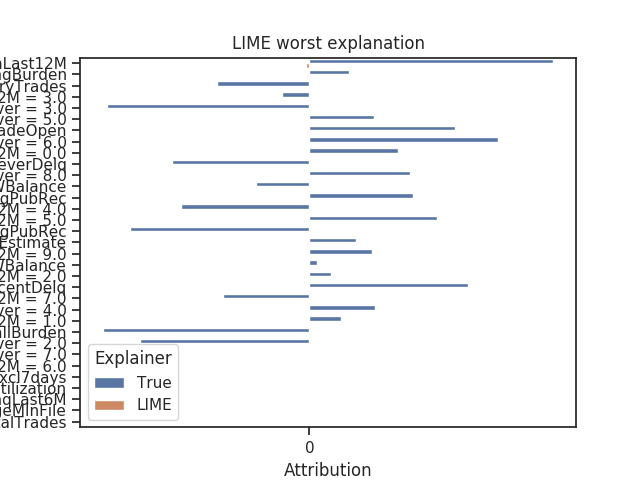

<IPython.core.display.Javascript object>


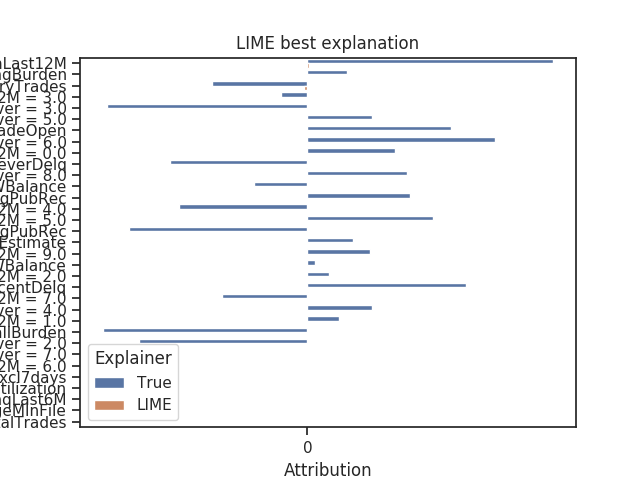

SHAP Top-3 worst explanations:


,Metric,Score,Explainer,Class,Sample Index
306,cosine_distances,3.569326e-07,SHAP,RiskPerformance = Good,6
308,cosine_distances,3.560679e-07,SHAP,RiskPerformance = Good,8
327,cosine_distances,3.553251e-07,SHAP,RiskPerformance = Good,27


SHAP Top-3 best explanations:


,Metric,Score,Explainer,Class,Sample Index
217,cosine_distances,1.669242e-07,SHAP,RiskPerformance = Bad,17
221,cosine_distances,1.668603e-07,SHAP,RiskPerformance = Bad,21
234,cosine_distances,1.667763e-07,SHAP,RiskPerformance = Bad,34


<IPython.core.display.Javascript object>


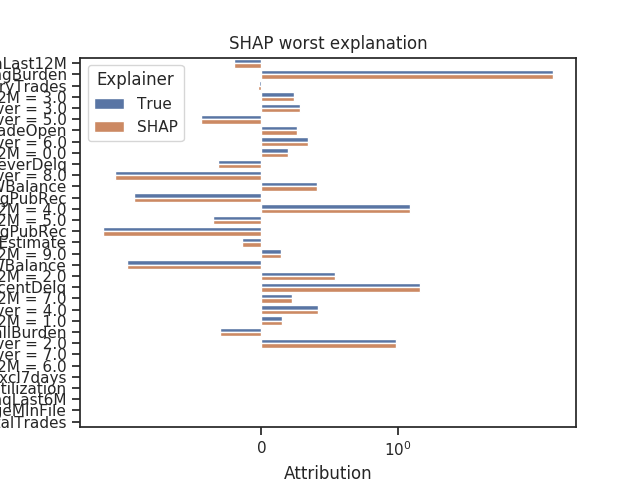

<IPython.core.display.Javascript object>


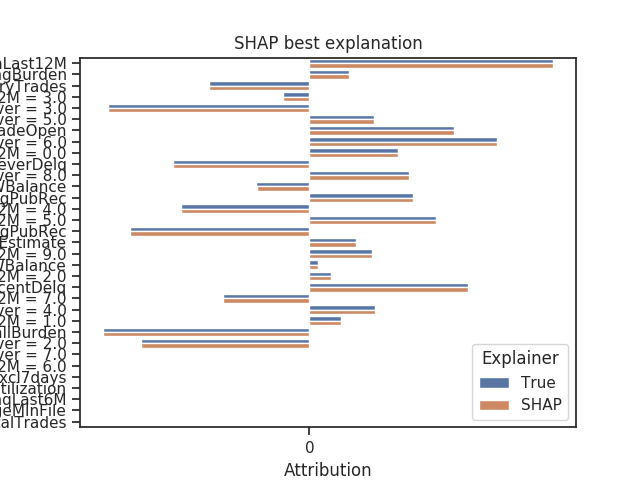

In [31]:
k = 3
worst_by = 'cosine_distances'
# worst_by = 'euclidean_distances'

# Top k worst explanations per explainer
df_effects = err_dfs['samplewise_err']
df_effects = df_effects[df_effects['Metric'] == worst_by]
for explainer_name, df_expl_effects in df_effects.groupby(['Explainer']):
    df_expl_effects = df_expl_effects.sort_values(by='Score', ascending=False)
    print(f'{explainer_name} Top-{k} worst explanations:')
    display(df_expl_effects.iloc[:k])
    print(f'{explainer_name} Top-{k} best explanations:')
    display(df_expl_effects.iloc[-k:])
    ax = plot_explanation(df_expl_effects.iloc[0])
    ax.set_title(f'{explainer_name} worst explanation')
    ax = plot_explanation(df_expl_effects.iloc[-1])
    ax.set_title(f'{explainer_name} best explanation')

In [26]:
y_model_subset = model.predict(X_subset)
if task == 'classification':
    y_pred_expl = np.argmax(y_pred_expl, axis=0)
    acc = metrics.accuracy(y_subset, y_model_subset)
    print(f'Model accuracy={acc * 100:.2f}')
else:
    err = metrics.rmse(y_subset, y_model_subset)
    print(f'Model rmse={err:.3g}')
    
for explainer_name, y_pred_expl in pred_y_map.items():
    if task == 'classification':
        y_pred_expl = np.argmax(y_pred_expl, axis=0)
        acc = metrics.accuracy(y_model_subset, y_pred_expl)
        print(f'{explainer_name} accuracy={acc * 100:.2f}')
    else:
        err = metrics.rmse(y_model_subset, y_pred_expl)
        print(f'{explainer_name} rmse={err:.3g}')

Model accuracy=32.00
LIME accuracy=100.00
SHAP accuracy=100.00
